In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
from mike_code import LaguerreAmplitudes
import matplotlib.cm as cm
from skimage.transform import resize_local_mean

In [2]:
#getting min/max bounds- helpful for future plots
def find_vmin_vmax(min, max):
    if abs(min) < abs(max):
        min = -abs(max)
    elif abs(min)>abs(max):
        max = abs(min)
    return min, max

In [3]:
def beef_it(image_path, rescale_factor, rscale, recon_lims, save_loc = None, savestr = None):
    #feed in a path to your image, the factor by which you want to scale up the image (to avoid issues with pixels, just makes image bigger)
    #the rscale for the expansion, the radius (in OG pixels) outside of which you don't want to reconstruct (a bit bigger than the galaxy)
    # and the save location

    #### need to build this out more but this is an ok start
    try: 
        im1 = np.asarray(Image.open(image_path))
    except:
        print('uhoh - no image to open, try a different path')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))
    ax1.imshow(im1[:,:,0], cmap='binary')
    ax2.imshow(im1[:,:,1], cmap='binary')
    ax3.imshow(im1[:,:,2], cmap='binary')
    ax1.set(title='channel 0')
    ax2.set(title='channel 1')
    ax3.set(title='channel 2')
    
    #############################
    ####### rescaling
    #############################
    av_im1 = np.mean(im1, axis=2)
    s = rescale_factor #we want to size this image up by a factor of s
    av_im1 = resize_local_mean(av_im1, (int(s*av_im1.shape[0]),int(s*av_im1.shape[0])))
    
    #############################
    ########  BFE 
    #############################
    xp = np.linspace(-av_im1.shape[0]/2.,av_im1.shape[0]/2.,av_im1.shape[0]) #getting x, y array
    xpix,ypix = np.meshgrid(xp,xp)
    rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix) #transforming to r, phi
        
        
    rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
    phi  = np.arctan2(ypix,xpix).reshape(-1,)
    av_im1flat = av_im1.reshape(-1,).copy() #need a copy
    
    # pick a radius of the image where we ignore everything outside of that radius
    gvals = np.where(rval>recon_lims*s)
        
    rval[gvals]         = np.nan
    phi[gvals]          = np.nan
    av_im1flat[gvals] = np.nan
    
    #
    # pick orders for the expansion
    mmax = 8  
    nmax = 12 #twelve makes the mapping to notes easier #8, 12
        
    # pick a scalelength for the reconstruction
    rscl = rscale*s ### 5 is p good
    
    # make the expansion and compute the weights
    # input into LaguerreAmplitudes is rscl, mmax, nmax, R, phi, mass=1., velocity=1.
    LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,av_im1flat) #this computes everything
    cos_cos, sin_cos = LG.laguerre_amplitudes_returns() #this returns the cosine and sine amplitudes
          
    LG.laguerre_reconstruction(rr,pp) #reconstructing the image using the BEF, computing the brightness at each r, phi in the image
    #############################
    ######## result plots!
    #############################
    plt.figure()
    plt.title('zoom in on center region, where reconstruction tends to struggle')
    plt.imshow((LG.reconstruction)[150*s:250*s,150*s:250*s],vmin=np.nanmin(av_im1), vmax=np.nanmax(av_im1),cmap='rainbow')
    
    print('max, min, median of reconstruction:', np.max(LG.reconstruction), np.min(LG.reconstruction), np.median(LG.reconstruction))
    print('max, min, median of original image:', np.max(av_im1), np.min(av_im1), np.median(av_im1))
    # make a figure for the comparison of real to reconstruction
    fig = plt.figure(figsize=(20,10),facecolor='white')
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    cval = np.linspace(-5.,1.,32)
    ax1.imshow((av_im1), cmap=plt.cm.magma)
    ax2.imshow((LG.reconstruction),vmin=np.nanmin(av_im1), vmax=np.nanmax(av_im1),cmap=cm.magma)
    
    # plot the relative uncertainty (maxed out at 100 percent)
    cb = ax3.imshow((LG.reconstruction-av_im1)/np.where(av_im1==0, np.nan, av_im1),vmin=-1,vmax=1,cmap=cm.bwr)
    
    cax = fig.add_axes([0.91, 0.25, 0.01, 0.5])
    fig.colorbar(cb, cax, orientation = 'vertical', label=r'$\frac{reconstruction - original}{original}$',extend='both') 
    
    
    ax1.set_title('image')
    ax2.set_title('reconstruction')
    ax3.set_title('relative uncertainty')
    if (savestr != None) and (save_loc != None):
        plt.savefig(str(save_loc)+str(savestr)+'.jpeg')

    print('returning reconstruction, cosine coefficients, and sine coefficients')
    return LG.reconstruction, cos_cos, sin_cos

def plot_coefficients(cosco, sinco, mmax, nmax):
     #############################
    ####### plotting coefficients - 
    #############################
        
    min_max_av_im1_c = (cosco.copy()).flatten()
    min_max_av_im1_s = (sinco.copy()).flatten()
    #getting minimum, maximums for coefficients (helpful in setting color range)
    min_b_s, max_b_s = np.min(min_max_av_im1_s), np.max(min_max_av_im1_s)
    min_b_c, max_b_c = np.min(min_max_av_im1_c), np.max(min_max_av_im1_c)
    
    vmin_av_im1_c, vmax_av_im1_c = find_vmin_vmax(min_b_c, max_b_c)
    vmin_av_im1_s, vmax_av_im1_s = find_vmin_vmax(min_b_s, max_b_s)
    
    #plotting heat map of the coefficients 
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.set_title('cosine')
    im = ax1.imshow(cosco.T,cmap='bwr',vmin=vmin_av_im1_c, vmax=vmax_av_im1_c)
    fig.colorbar(im, ax=ax1, label='Cos Coeff')
    # Show all ticks and label them with the respective list entries
    ax1.set_xticks(np.arange(mmax), labels=np.arange(mmax))
    ax1.set_yticks(np.arange(nmax), labels=np.arange(nmax))
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    ax1.set_xlabel('m')
    ax1.set_ylabel('n')
    
    ax2.set_title('sine')
    im = ax2.imshow(sinco.T,cmap='bwr',vmin=vmin_av_im1_s, vmax=vmax_av_im1_s) #sinco.T
    fig.colorbar(im, ax=ax2, label='Sin Coeff')
    # Show all ticks and label them with the respective list entries
    ax2.set_xticks(np.arange(mmax), labels=np.arange(mmax))
    ax2.set_yticks(np.arange(nmax), labels=np.arange(nmax))
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    ax2.set_xlabel('m')
    ax2.set_ylabel('n')
    return

In [4]:
from mingus.containers import NoteContainer, Note, Bar
import mingus.core.notes as notes
import mingus.core.keys as keys
from mingus.midi import fluidsynth
from mingus.containers import Composition
from mingus.containers import Track
from mingus.containers.instrument import MidiInstrument
import time
#what is the highest amplitude coeefficient (looking at both sin and cos)
#original note_list = np.sort(np.array(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']))[::-1]
### note_list = np.array(['C','D','E','F','G','A','B'])# this is C major the last 'C'is at higher octave
note_list = np.array(['Gb','Db','Ab','Eb','Bb','F','C','G','D','A','E','B','F#','C#','G#','D#','A#']) #pythagorean chromatic scale

######
#need to initialize fluidsynth with our soundfont - this just tells fluidsynth where our sounds live
fluidsynth.init("/Users/caf/Developer/sonify/env/GeneralUser GS 1.471/soundfont.sf2")#,'coreaudio')
#coreaudio, file, portaudio seem to be only viable options
#possible drivers:  ‘alsa’, ‘oss’, ‘jack’, ‘portaudio’, ‘sndmgr’, ‘coreaudio’, ‘Direct Sound’, ‘dsound’, ‘pulseaudio’

#####################
#### setting instruments for positive, negative channels
#####################
fluidsynth.set_instrument(1,1) #put piano on channel 1 - positive notes will be piano
fluidsynth.set_instrument(2,49) #put string ensemble on channel 2 - negative notes will be strings


def map_to_sounds(cos_cos, sin_cos, mmax, nmax):
    min_max_bar_c = (cos_cos.copy()).flatten()
    min_max_bar_s = (sin_cos.copy()).flatten()
    
    #what is the highest amplitude coeefficient (looking at both sin and cos)
    min_max_av_im1_c = (cos_cos.copy()).flatten()
    min_max_av_im1_s = (sin_cos.copy()).flatten()
    #getting minimum, maximums for coefficients (helpful in setting color range)
    min_b_s, max_b_s = np.min(min_max_av_im1_s), np.max(min_max_av_im1_s)
    min_b_c, max_b_c = np.min(min_max_av_im1_c), np.max(min_max_av_im1_c)
    
    vmin_av_im1_c, vmax_av_im1_c = find_vmin_vmax(min_b_c, max_b_c)
    vmin_av_im1_s, vmax_av_im1_s = find_vmin_vmax(min_b_s, max_b_s)
    
    abs_max = np.max(np.array([np.max(abs(min_max_bar_c)),np.max(abs(min_max_bar_s))]))
    
    c_bar_copy = cos_cos.copy()
    s_bar_copy = sin_cos.copy()
    note_cos = NoteContainer()
    note_sin = NoteContainer()
    note_tote = NoteContainer()
    for m in range(mmax):
        octave = m
        for n in range(nmax):
            amp_c = c_bar_copy[m,n]
            amp_s = s_bar_copy[m,n]
            if abs(amp_c) >= .025*abs_max: #if the amplitude of this coefficient is at least 2.5% the maximum, we will make it audible
                if amp_c > 0: #if the amplitude is positive, use channel one so we can use different instruments for positive and negative coeffs
                    noteys = Note(note_list[n],octave=octave,channel=1)
                    note_cos.add_notes(noteys)
                    note_tote.add_notes(noteys)
                else: #if the amplitude is negative, use channel two
                    noteys = Note(note_list[n],octave=octave,channel=2)
                    note_cos.add_notes(noteys)
                    note_tote.add_notes(noteys)
            
            if abs(amp_s) >= .025*abs_max: #repeat for sin
                if amp_s > 0:
                    noteys = Note(note_list[n],octave=octave,channel=1)
                    note_sin.add_notes(noteys)
                    note_tote.add_notes(noteys)
                else:
                    noteys = Note(note_list[n],octave=octave,channel=2)
                    note_sin.add_notes(noteys)
                    note_tote.add_notes(noteys)
    print('returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients')
    return note_tote,  note_cos, note_sin

# starting!

In [5]:
#cos_cos.shape #The first two dimensions (M, N) define the rows and columns of the image.

returning coscoefs, sincoefs
max, min, median of reconstruction: 288.8245862642244 -0.0336310986992233 0.0014029967853202963
max, min, median of original image: 144.33333333333334 0.0 5.0
returning reconstruction, cosine coefficients, and sine coefficients
returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients


True

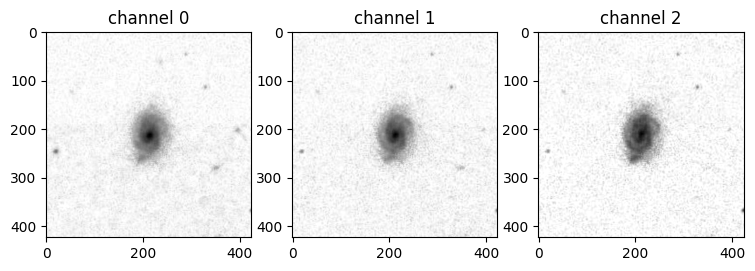

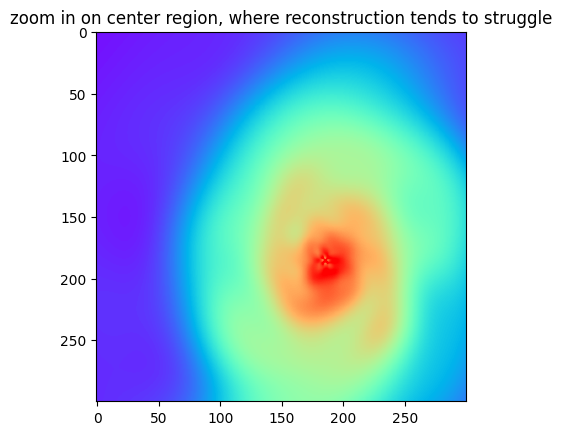

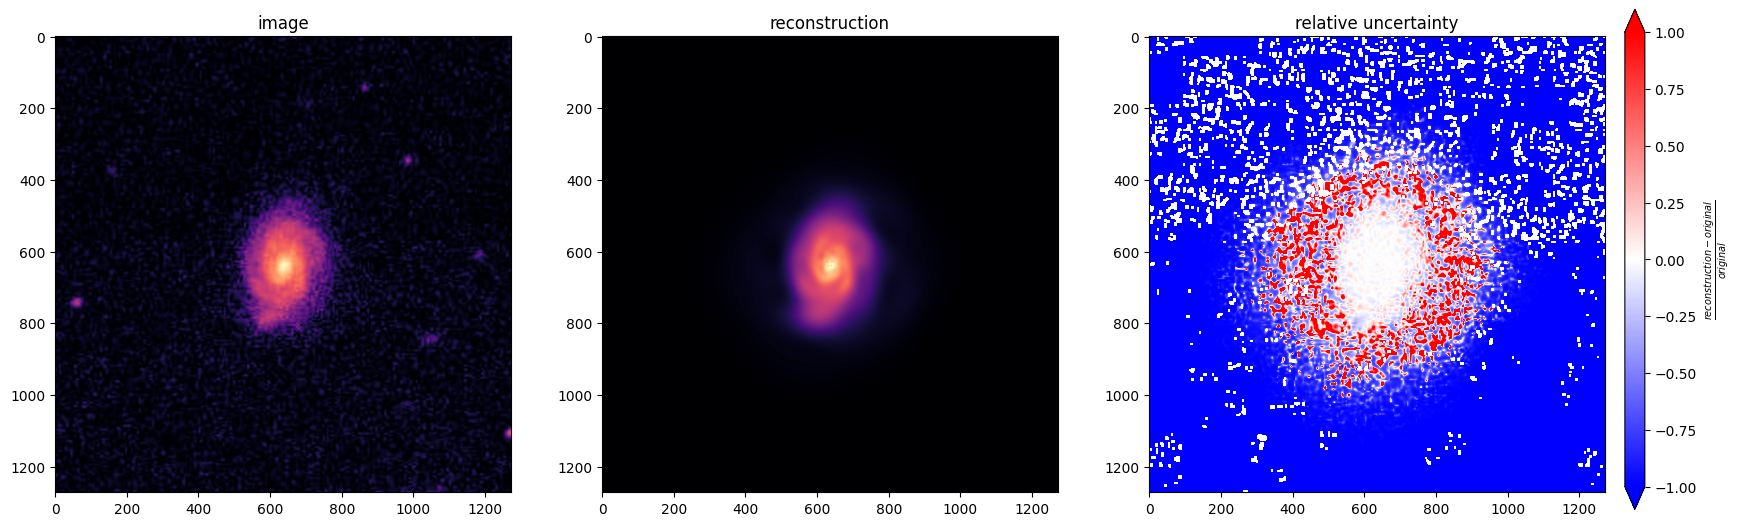

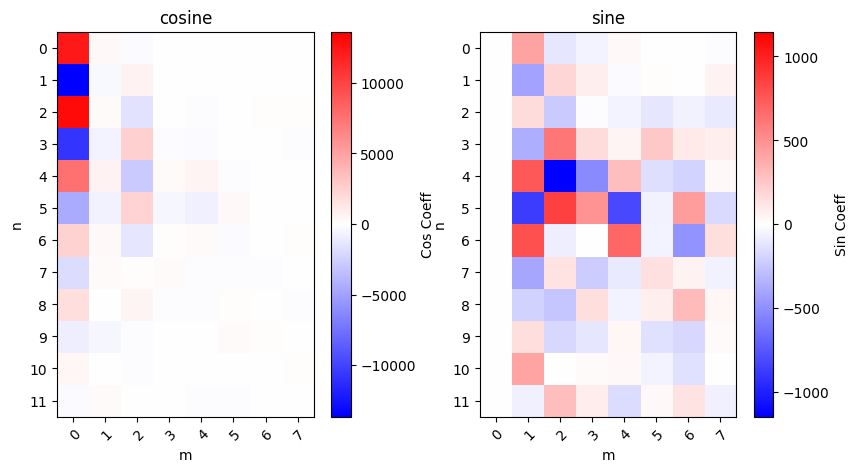

In [6]:
#image_path, rescale_factor, rscale, recon_lims, save_loc = None, savestr = None
recon, cos_cos, sin_cos = beef_it('./galaxyzoo_2_data/images/18.jpg', 3, 
                                  5, 100, save_loc = './', savestr = 'galaxy_18_recon')
plot_coefficients(cos_cos, sin_cos, mmax = 8, nmax = 12)
#    mmax = 8  nmax = 12
####

note_tote_1, note_cos_1, note_sin_1 = map_to_sounds(cos_cos, sin_cos, mmax = 8, nmax = 12)
#play the sounds for bar!
fluidsynth.play_NoteContainer(note_tote_1, channel=[note.channel for note in note_tote_1])
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(note_tote_1))

# next -

returning coscoefs, sincoefs
max, min, median of reconstruction: 292.19410657571956 -1.0411051962233533 0.00014734372194022584
max, min, median of original image: 154.66666666666666 0.0 4.666666666666667
returning reconstruction, cosine coefficients, and sine coefficients
returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients


True

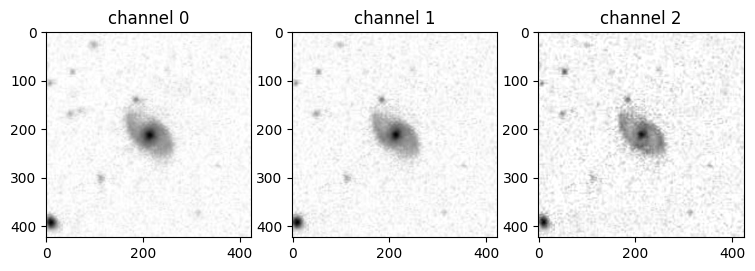

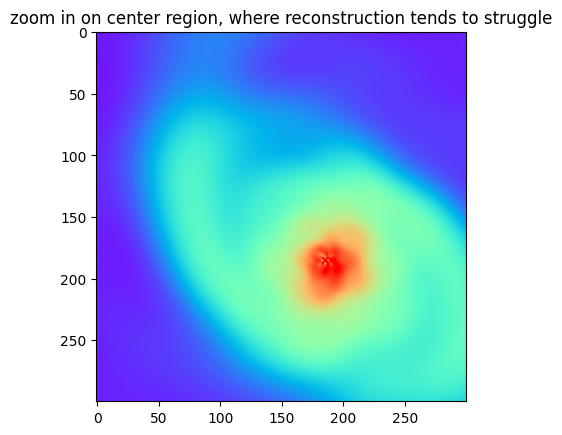

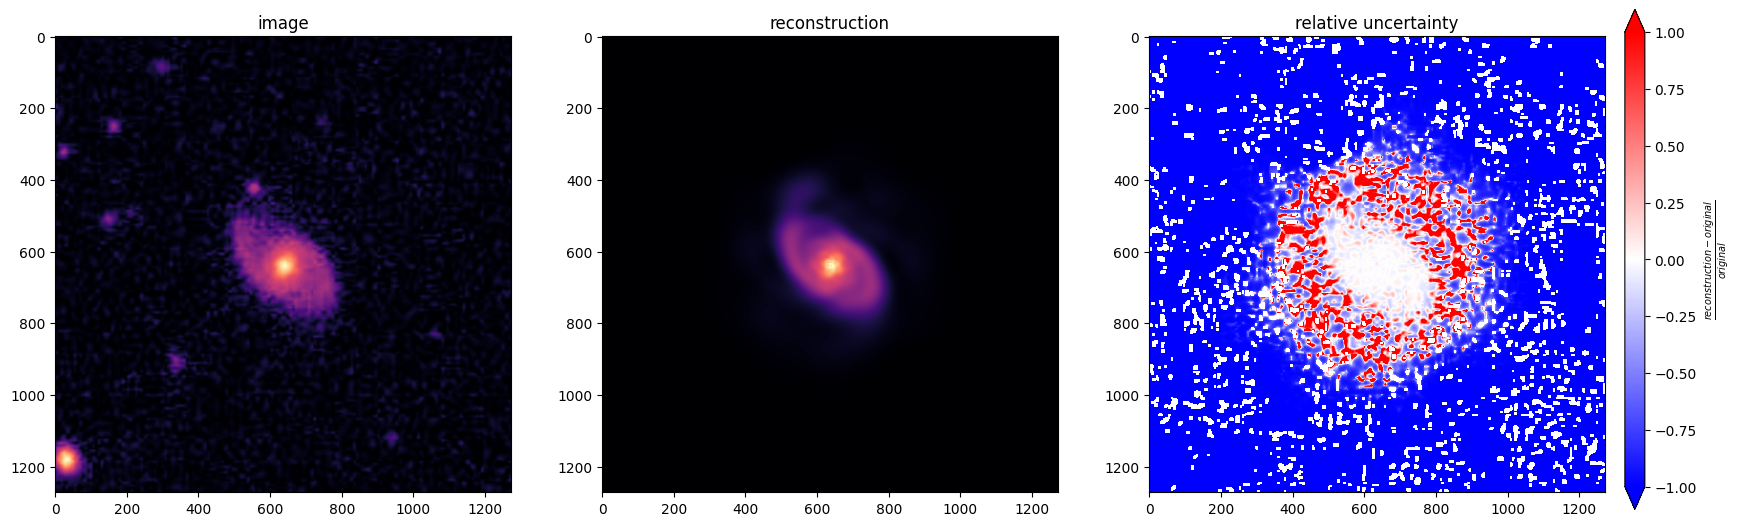

In [7]:
recon, cos_cos, sin_cos = beef_it('./galaxyzoo_2_data/images/21.jpg', 3, 
                                  5, 100, save_loc = './', savestr = 'galaxy_21_recon')


note_tote_2, note_cos_2, note_sin_2 = map_to_sounds(cos_cos, sin_cos, mmax = 8, nmax = 12)
#play the sounds for bar!
fluidsynth.play_NoteContainer(note_tote_2, channel=[note.channel for note in note_tote_2])
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(note_tote_2))

# next

returning coscoefs, sincoefs
max, min, median of reconstruction: 209.93699677653254 -0.9518458756857491 0.03371144596387533
max, min, median of original image: 172.0 0.0 5.333333333333333
returning reconstruction, cosine coefficients, and sine coefficients
returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients


True

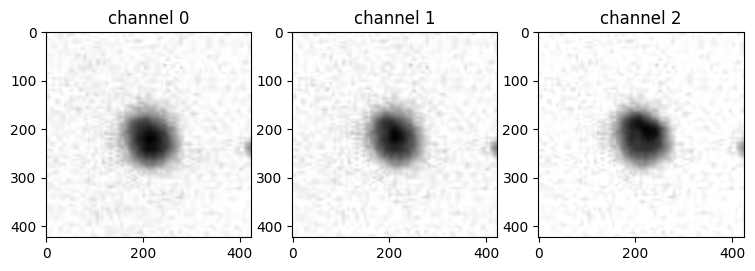

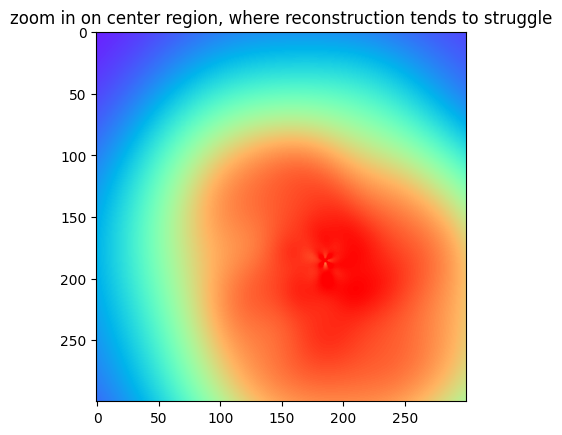

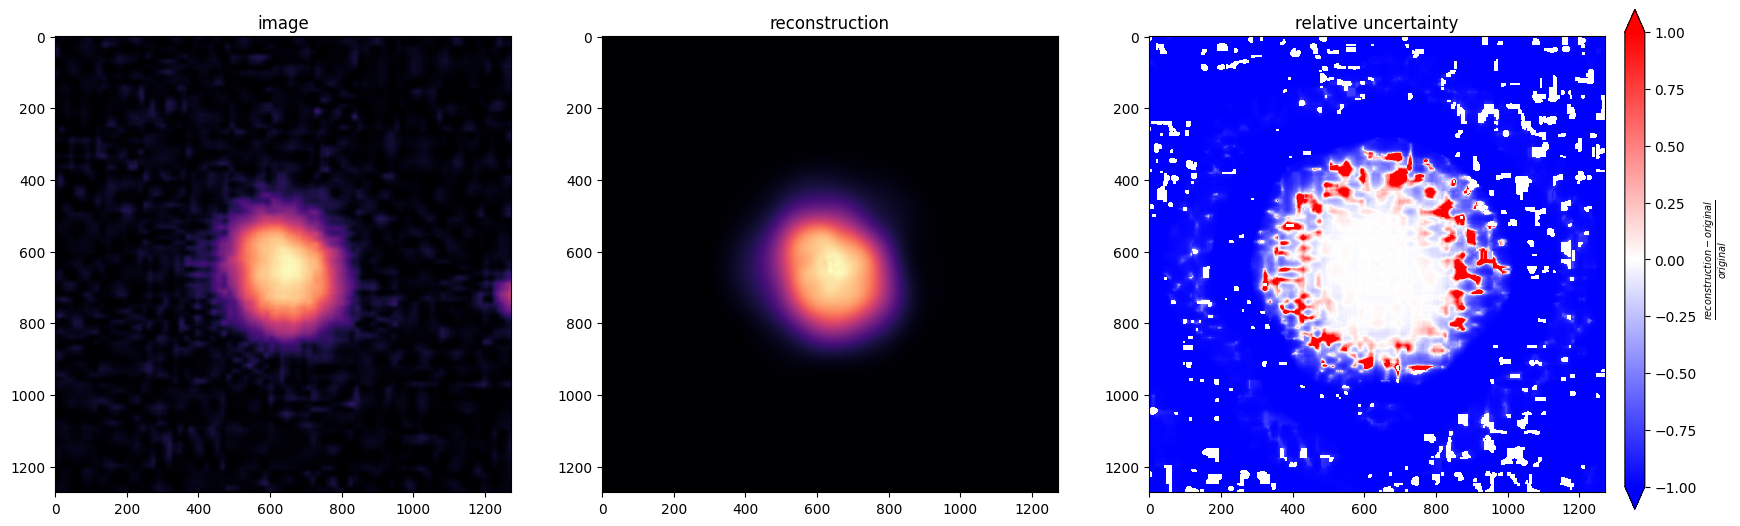

In [8]:
recon, cos_cos, sin_cos = beef_it('./galaxyzoo_2_data/images/127.jpg', 3, 
                                  15, 100, save_loc = './', savestr = 'galaxy_127_recon') #tried 5

note_tote_3, note_cos_3, note_sin_3 = map_to_sounds(cos_cos, sin_cos, mmax = 8, nmax = 12)
#play the sounds for bar!
fluidsynth.play_NoteContainer(note_tote_3, channel=[note.channel for note in note_tote_3])
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(note_tote_3))

In [9]:
.025*np.max(np.array([np.max(abs(cos_cos)),np.max(abs(sin_cos))]))

1032.4011347337607

In [10]:
sin_cos[abs(sin_cos)>1032]

array([ 2080.10592159, -5065.53185181,  4278.90947007, -1798.04872549,
        1185.87459274, -2894.22811254,  2287.30584656])

In [11]:
plot_coefficients(cos_cos, sin_cos)

TypeError: plot_coefficients() missing 2 required positional arguments: 'mmax' and 'nmax'

# junk below-

Text(0.5, 1.0, 'relative uncertainty')

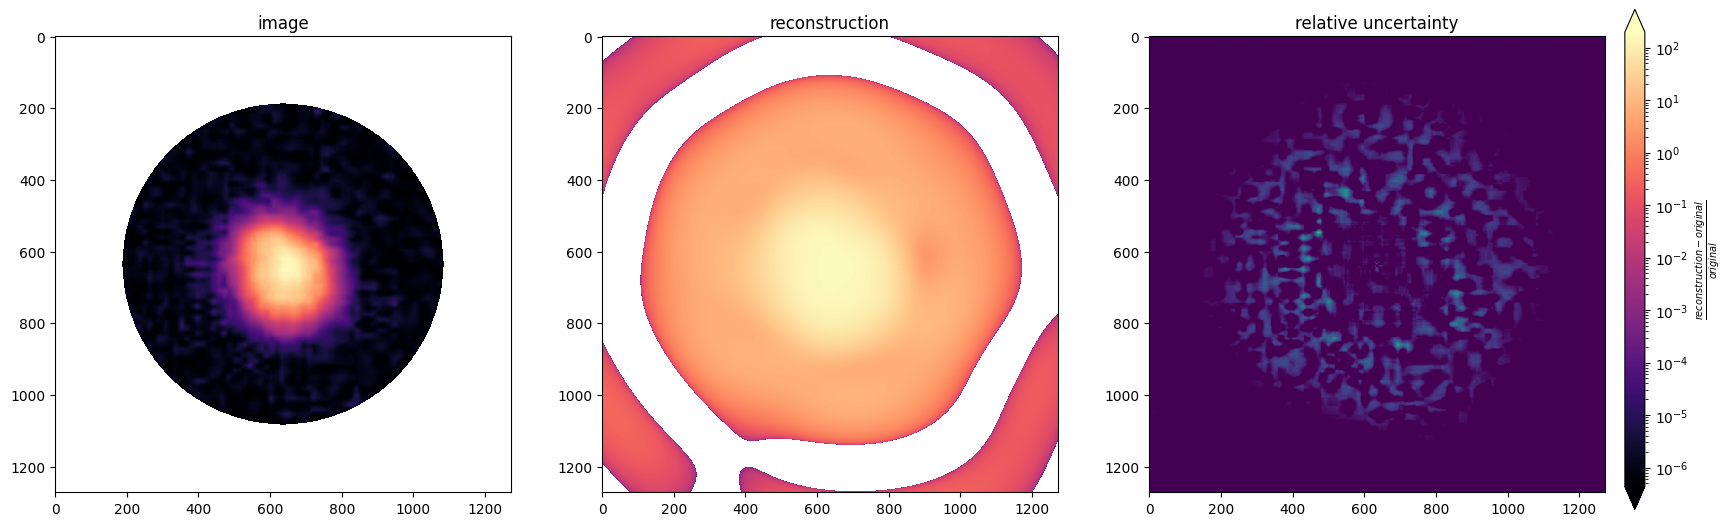

In [85]:
#in logscale, it is white where values are negative
import matplotlib
fig = plt.figure(figsize=(20,10),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow(av_im3flat.reshape(av_im3.shape),cmap=plt.cm.magma)
#    np.where(av_im3<LG.reconstruction, np.nan, av_im3), cmap=plt.cm.magma)
cb1 = ax2.imshow((LG.reconstruction),cmap=cm.magma,norm=matplotlib.colors.LogNorm())#vmin=np.nanmin(av_im3), vmax=np.nanmax(av_im3),

# plot the relative uncertainty (maxed out at 100 percent)
cb = ax3.imshow((LG.reconstruction-av_im3), vmin=0)#,vmin=-1,vmax=1,cmap=cm.bwr)

cax = fig.add_axes([0.91, 0.25, 0.01, 0.5])
fig.colorbar(cb1, cax, orientation = 'vertical', label=r'$\frac{reconstruction - original}{original}$',extend='both') 


ax1.set_title('image')
ax2.set_title('reconstruction')
ax3.set_title('relative uncertainty')
